In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.utils import print_summary
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.1.0


Using TensorFlow backend.


In [2]:
trainDF = pd.read_csv('/home/jupyter/Project/train.txt', sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Project/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,66))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,66))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [3]:
from keras.regularizers import l2

def VGG_FE(width, height, depth):

    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


In [4]:
NUM_EPOCHS = 30

model = VGG_FE(width=66, height=200, depth=3)
print (model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="mse")

filepath = "/home/jupyter/Project/VGG/VGG_FE_Chekpoints/VGG_FE_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
# callbacks_list = [checkpoint1]

history = model.fit(
                train_generator,
                steps_per_epoch=329,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=37,
                callbacks=[checkpoint])

# model.save_weights(filepath)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1164)              7152780   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1164)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               116500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

/home/jupyter/.local/lib/python3.5/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/30
329/329 [==============================] - 124s 376ms/step - loss: 0.1550 - val_loss: 0.0024

Epoch 00002: val_loss did not improve from 0.00159
Epoch 3/30
329/329 [==============================] - 125s 380ms/step - loss: 0.1490 - val_loss: 0.0811

Epoch 00003: val_loss did not improve from 0.00159
Epoch 4/30
329/329 [==============================] - 124s 377ms/step - loss: 0.1094 - val_loss: 0.0120

Epoch 00004: val_loss did not improve from 0.00159
Epoch 5/30
329/329 [==============================] - 123s 375ms/step - loss: 0.0934 - val_loss: 0.0364

Epoch 00005: val_loss did not improve from 0.00159
Epoch 6/30
329/329 [==============================] - 124s 378ms/step - loss: 0.0798 - val_loss: 0.0885

Epoch 00006: val_loss did not improve from 0.00159
Epoch 7/30
329/329 [==============================] - 124s 377ms/step - loss: 0.0679 - val_loss: 0.0161

Epoch 00007: val_loss did not improve from 0.00159
Epoch 8/30
329/329 [==============================] - 125s 379ms

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


avg_train_loss: 0.05239775392958009
avg_val_loss: 0.7341998379250678
difference: -0.6818020839954877


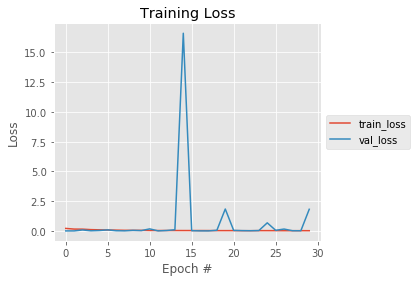

In [5]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(avg_train_loss - avg_val_loss))

In [6]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Project/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 66))

filepath = "/home/jupyter/Project/VGG/VGG_FE_Chekpoints/VGG_FE_weights.01-0.00.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [7]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 1928.2597652030115
len(df_preds): 8951
MAE: 0.21542394874349363


In [8]:
df_preds[8900:]

,Images,Actual Steering Angle,Predicted Steering Angle,MAE
8900,45355.jpg,0.103847,0.012694,0.091153
8901,45356.jpg,0.100356,0.012955,0.087401
8902,45357.jpg,0.093201,0.008217,0.084983
8903,45358.jpg,0.089710,0.007470,0.082240
8904,45359.jpg,0.086219,0.005842,0.080377
8905,45360.jpg,0.080983,0.004108,0.076875
8906,45361.jpg,0.074002,0.001799,0.072203
8907,45362.jpg,0.074002,0.002146,0.071856
8908,45363.jpg,0.066846,0.001079,0.065767
8909,45364.jpg,0.063355,0.003023,0.060332
